In [1]:
from gensim.models import word2vec
from tensorflow.keras import preprocessing
import matplotlib.pyplot as plt
from pyvi import ViTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.dtprocess import cleandt
from function.embedding import PatchEmbedding, MeanVectorizer

In [58]:
# from google.colab import drive
# drive.mount('/content/drive')

In [59]:
# %cd /content/drive/My Drive/Colab Notebooks/Text_Generator

In [60]:
# %ls -la

## Import and normalize data

In [2]:
news = pd.read_csv('./data/vnexpress/csv/cleaned_vnexpress.csv').drop(columns='Unnamed: 0', axis=1)
print(news.shape)

(2481, 5)


In [3]:
print(news.info())
news.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  2481 non-null   int64 
 1   topic       2481 non-null   object
 2   sub-topic   2481 non-null   object
 3   url         2481 non-null   object
 4   tag         2479 non-null   object
dtypes: int64(1), object(4)
memory usage: 97.0+ KB
None


,article_id,topic,sub-topic,url,tag
0,0,doi-song,to-am,https://vnexpress.net/buc-tuong-hoa-hong-bao-q...,khi mua ngôi nhà mới ở bắc california cả mảnh ...
1,1,doi-song,to-am,https://vnexpress.net/vo-phat-hien-tung-du-dam...,cô gái 24 tuổi ở quần_đảo bangkabelitung indon...
2,2,doi-song,to-am,https://vnexpress.net/70-ngay-keo-vo-va-con-tr...,mọi thứ ập đến với anh quá nhanh khoảng 7h sán...
3,3,doi-song,to-am,https://vnexpress.net/nhung-dua-tre-duoc-bat-d...,mẹ bảo hồi bằng tuổi cháu cũng yêu một bạn cùn...
4,4,doi-song,to-am,https://vnexpress.net/doi-bi-kich-cua-nguoi-ph...,tôi suy_sụp đứng không vững nhưng phải tự trấn...


In [4]:
news.isna().sum()

article_id    0
topic         0
sub-topic     0
url           0
tag           2
dtype: int64

In [5]:
news.dropna(axis=0, inplace=True)
news.reset_index(inplace=True)
news.drop(columns=['index'], axis=1, inplace=True)

In [6]:
news['tag'] = news['tag'].apply(lambda x: cleandt.remove_stopword(x, './data/vietnamese-stopwords-dash.txt'))

In [7]:
print(news['topic'].value_counts())
news

topic
giai-tri    616
the-thao    510
khoa-hoc    450
doi-song    363
giao-duc    358
du-lich     182
Name: count, dtype: int64


,article_id,topic,sub-topic,url,tag
0,0,doi-song,to-am,https://vnexpress.net/buc-tuong-hoa-hong-bao-q...,mua bắc california mảnh vườn 670 m2 cây_xanh d...
1,1,doi-song,to-am,https://vnexpress.net/vo-phat-hien-tung-du-dam...,gái 24 quần_đảo bangkabelitung indonesia tình ...
2,2,doi-song,to-am,https://vnexpress.net/70-ngay-keo-vo-va-con-tr...,ập 7h 143 chiến bật dậy tiếng kêu vợ cử_động c...
3,3,doi-song,to-am,https://vnexpress.net/nhung-dua-tre-duoc-bat-d...,mẹ bảo hồi cháu yêu lớp yêu tâm_trạng cháu bé ...
4,4,doi-song,to-am,https://vnexpress.net/doi-bi-kich-cua-nguoi-ph...,suy_sụp đứng vững trấn_an dựa sen 60 xã kim li...
...,...,...,...,...,...
2474,2476,the-thao,tuong-thuat,https://vnexpress.net/philadelphia-vs-inter-mi...,ghi_bàn bedoya 73 martinez 3 messi 20 alba 45 ...
2475,2477,the-thao,tuong-thuat,https://vnexpress.net/inter-miami-vs-charlotte...,ghi_bàn martinez phạt_đền 12 taylor 32 malanda...
2476,2478,the-thao,tuong-thuat,https://vnexpress.net/arsenal-vs-man-city-4638...,ghi_bàn trossard 9011 palmer 77 danh_hiệu mùa ...
2477,2479,the-thao,tuong-thuat,https://vnexpress.net/viet-nam-vs-ha-lan-46364...,ghi_bàn martens 8 snoeijs 11 brugts 18 57 roor...


## Create word embedding model from Word2Vec

In [8]:
sequences = news['tag'].to_list()
input_gensim = []

for sen in sequences:
  input_gensim.append(sen.split())

In [24]:
# model = word2vec.Word2Vec(input_gensim, vector_size=128, window=5, min_count=0, workers=4, sg=1)
# model.save("./model/word.model")

In [9]:
model = word2vec.Word2Vec.load("./model/word.model")

## Find similar texts by Cosine measure

In [10]:
question = '''
Với CLB Hà Lan, tiền đạo cánh người Brazil đạt tỷ lệ ghi bàn và kiến tạo kỳ vọng là 0,58, chỉ xếp thứ 14 nếu đặt ở Ngoại hạng Anh. Ngoài ra, Antony cũng được "thổi phồng" nhờ chơi cho CLB vượt trội về tài chính và lực lượng so với phần còn lại của giải vô địch Hà Lan.
'''

In [18]:
pemb = PatchEmbedding(word_model=model, stopword_path="./data/vietnamese-stopwords-dash.txt")

question_embeddings = pemb.sentence_embedding(question)
post_embeddings = pemb.post_embedding(input_gensim, length=len(input_gensim))

After tonkenized: 
 Với CLB Hà_Lan , tiền_đạo cánh Brazil tỷ_lệ ghi_bàn kiến_tạo kỳ_vọng 0,58 , xếp 14 Ngoại_hạng Anh . Ngoài_ra , Antony " thổi_phồng " CLB vượt_trội tài_chính lực_lượng giải vô_địch Hà_Lan . 



In [19]:
print(len(question_embeddings))
question_embeddings[0]

14


array([-3.07039022e-01, -5.01093388e-01,  3.11660707e-01,  3.71207520e-02,
        1.18306018e-01,  1.48471370e-01, -1.00357816e-01,  1.71653301e-01,
        4.92142317e-06, -2.62266070e-01,  7.56144285e-01,  2.60302238e-02,
       -5.25379479e-01, -2.44061708e-01,  2.88974702e-01,  1.21494956e-01,
        4.06985968e-01,  5.36819138e-02, -1.33202225e-01,  3.77770066e-01,
        3.01582664e-01,  4.68646407e-01,  1.45097896e-02, -8.81599113e-02,
        2.95535386e-01,  4.83771367e-03, -8.40188190e-02,  2.54519701e-01,
        1.71749130e-01, -5.15135348e-01,  3.23688775e-01, -1.45166065e-03,
       -5.18321730e-02, -2.43539244e-01, -1.48592278e-01,  5.51705360e-02,
        2.81441897e-01, -1.41101599e-01,  3.24869603e-01, -1.16481567e-02,
       -1.40372276e-01, -2.04449326e-01, -3.01797211e-01,  5.25852323e-01,
        2.32888356e-01,  5.33719778e-01,  9.33399796e-02, -5.96002154e-02,
       -1.81360054e-03,  8.95466730e-02,  9.29352045e-02,  5.80048323e-01,
        1.66356623e-01,  

In [20]:
mvectorize = MeanVectorizer(word_model=model)

mean_sentence_embedding = mvectorize.mean_vector_embedding(question_embeddings)
mean_post_embedding = mvectorize.mean_posts_embedding(post_embeddings)

In [21]:
print('The len of the mean embedding vector:', len(mean_sentence_embedding))
print('The length of the mean embedding posts:', len(mean_post_embedding))

# Calculate similarity (cosine similarity)
similarity_score = mvectorize.text_cosine_similarity(mean_sentence_embedding, mean_post_embedding)

# Print the similarity score
print(f"Similarity Score: {similarity_score}")

The len of the mean embedding vector: 128
The length of the mean embedding posts: 2479
Similarity Score: [[0.7180508  0.7238443  0.7649199  ... 0.93573076 0.92541444 0.94324124]]


In [22]:
similar_news = mvectorize.find_similarity(similarity_score, news)

np_similarity_scores [[0.7180508  0.7238443  0.7649199  ... 0.93573076 0.92541444 0.94324124]]
Sorted Indices: [2345 2366 1989 ... 1895 1378 1940]
Top 5 Indices: [2345 2366 1989 2138 2344]


In [23]:
similar_news

,article_id,topic,sub-topic,url,tag
2345,2347,the-thao,photo,https://vnexpress.net/10-ngoi-sao-dang-cap-the...,almoez ali qatar nhân_tố giúp qatar vô_địch as...
2366,2368,the-thao,photo,https://vnexpress.net/nhung-nhan-to-dang-vut-s...,serhou guirassy áo trắng hiện_tượng dẫn_đầu da...
1989,1991,the-thao,bundesliga,https://vnexpress.net/kane-cham-tay-vao-giay-v...,tuần kane lập hattrick trận bayern thắng mainz...
2138,2140,the-thao,cac-mon-khac,https://vnexpress.net/usyk-thang-tyson-fury-th...,fury lẫn usyk võ_đài riyadh thành_tích bất_bại...
2344,2346,the-thao,photo,https://vnexpress.net/chu-nha-qatar-dai-thang-...,trình_độ qatar lấn_lướt chủ kiểm_soát bóng 62 ...


## Visualize the relationships

* The relationships among words

In [22]:
from sklearn.decomposition import PCA

In [23]:
def words_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [word for word in model.wv.vocab]
        
    word_vectors = np.array([model.wv[w] for w in words])
    
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y-0.50, word)

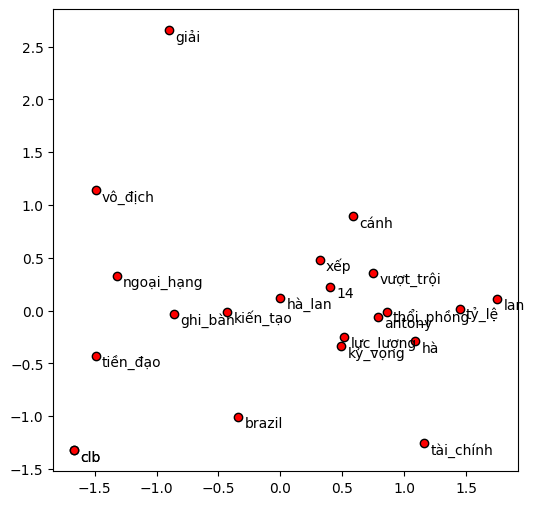

In [24]:
sentence = '''Với CLB Hà Lan tiền đạo cánh người Brazil đạt tỷ lệ ghi bàn và kiến tạo kỳ vọng là chỉ xếp thứ 14 nếu đặt ở Ngoại hạng Anh. 
Ngoài ra, Antony cũng được "thổi phồng" nhờ chơi cho CLB vượt trội về tài chính và lực lượng so với phần còn lại của giải vô địch Hà Lan'''

sentence = sentence.lower()
sentence = cleandt.remove_punctuation(sentence)
sentence = ViTokenizer.tokenize(sentence)
sentence = cleandt.remove_stopword(sentence, './data/vietnamese-stopwords-dash.txt')
words = sentence.split()

words_scatterplot(model, words)

* The relationships among documents

In [25]:
temp_embeddings = pemb.post_embedding(input_gensim, 100)
mean_temp_embedding = mvectorize.mean_posts_embedding(temp_embeddings)

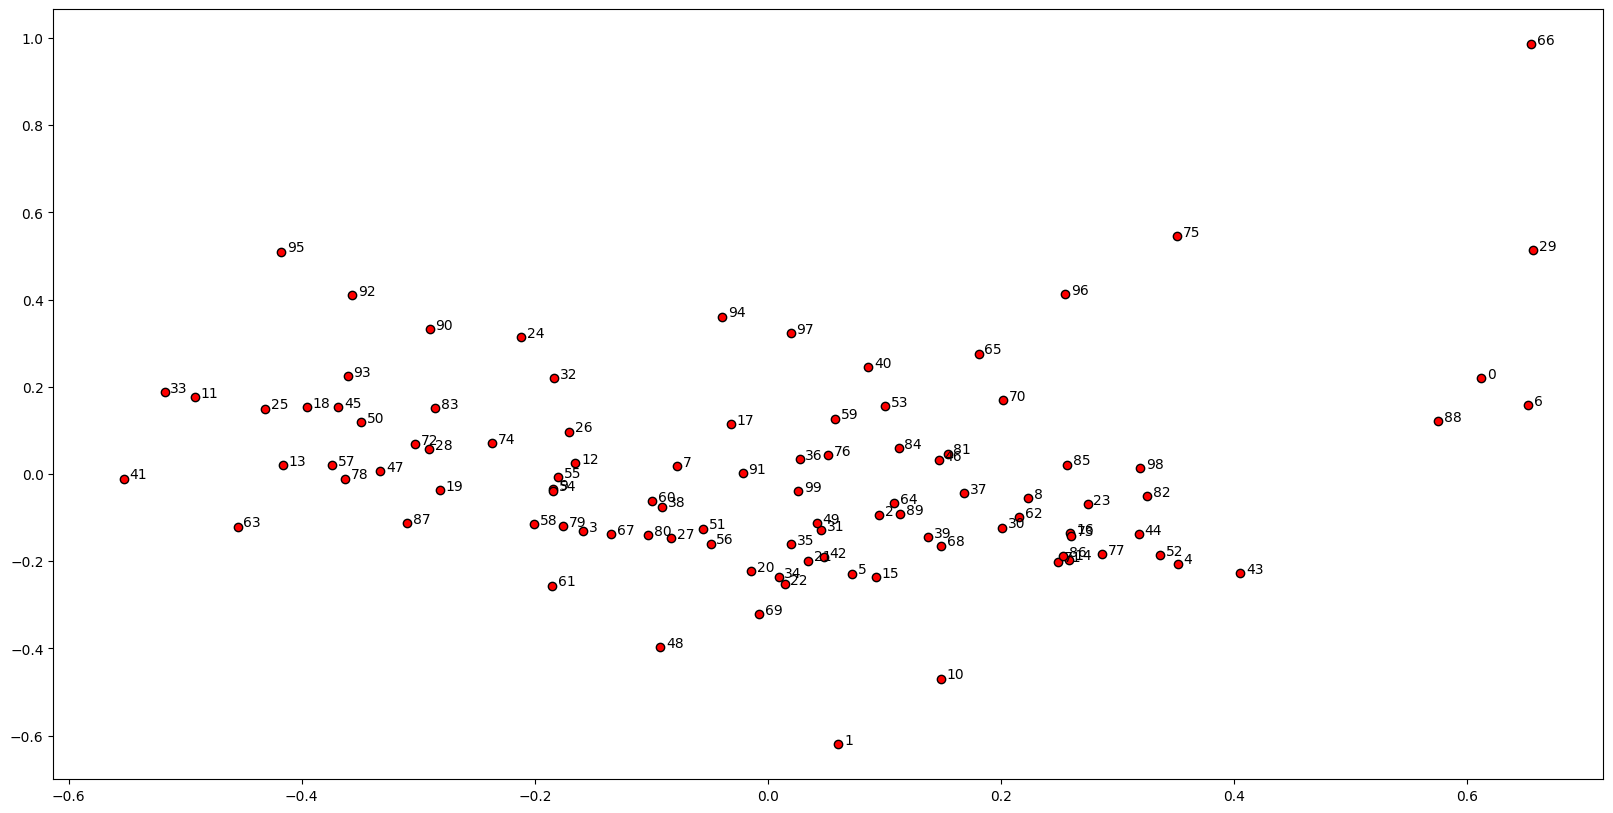

In [26]:
# mean_post_embedding
post_vectors = []
for post_embedding in mean_temp_embedding:
    post_vectors.append(post_embedding.tolist())

twodim = PCA().fit_transform(post_vectors)[:,:2]
index = [i for i,_ in enumerate(mean_temp_embedding)]

plt.figure(figsize=(20,10))
plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
for doc, (x,y) in zip(index, twodim):
    plt.text(x+0.005, y, doc)

## Text clustering with Kmean algorithm

In [24]:
text_embeddings = pemb.post_embedding(input_gensim)
    
print(len(text_embeddings))
print(len(text_embeddings[0]))

2418
304


In [25]:
mean_text_embeddings = mvectorize.flatten_mean_embedding(text_embeddings)
print(len(mean_text_embeddings))

100%|██████████| 2418/2418 [00:00<00:00, 2724.51it/s]

2418


In [26]:
# Đệm thêm 0 để đủ độ dài trong từng văn bản
max_length = max([len(i) for i in mean_text_embeddings])
mean_text_embeddings_padding = np.array(preprocessing.sequence.pad_sequences(mean_text_embeddings, maxlen=max_length, padding='pre', dtype='float32'))

In [27]:
from clusteval import clusteval
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

In [28]:
print("The shape of padding sequences array:", mean_text_embeddings_padding.shape)
print(mean_text_embeddings_padding[0:5])

The shape of padding sequences array: (2418, 1995)
[[ 0.          0.          0.         ... -0.01428613 -0.04728192
  -0.01155391]
 [ 0.          0.          0.         ... -0.0067737  -0.02587833
  -0.0193274 ]
 [ 0.          0.          0.         ... -0.02516341  0.00589586
  -0.02492141]
 [ 0.          0.          0.         ... -0.00740659 -0.02844947
  -0.02197713]
 [ 0.          0.          0.         ... -0.01391438 -0.00196861
  -0.03569172]]


In [88]:
# Set parameters, as an example dbscan
ce = clusteval(evaluate='silhouette', max_clust=20, normalize=True)

# Fit to find optimal number of clusters using dbscan
results = ce.fit(mean_text_embeddings_padding)

[clusteval] >INFO> Normalizing input data per feature (zero mean and unit variance)


[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


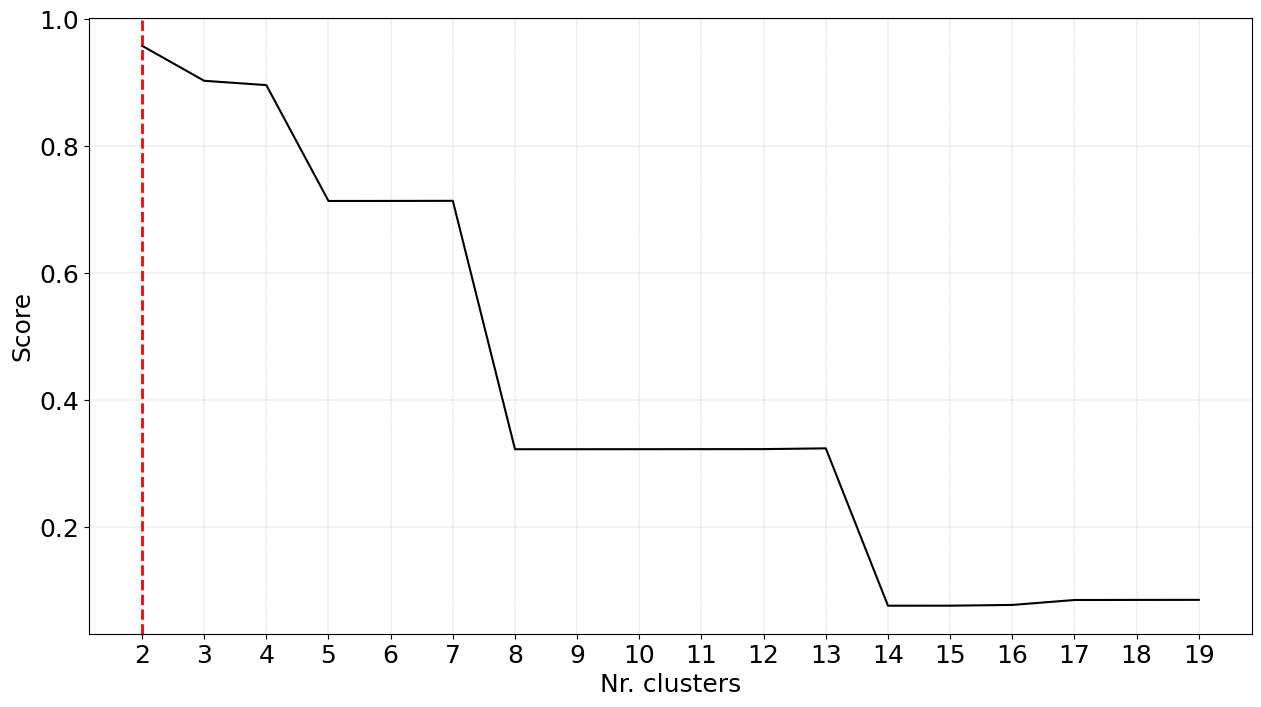

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [89]:
ce.plot(verbose=0)

Text(0, 0.5, 'Sum of squared distance')

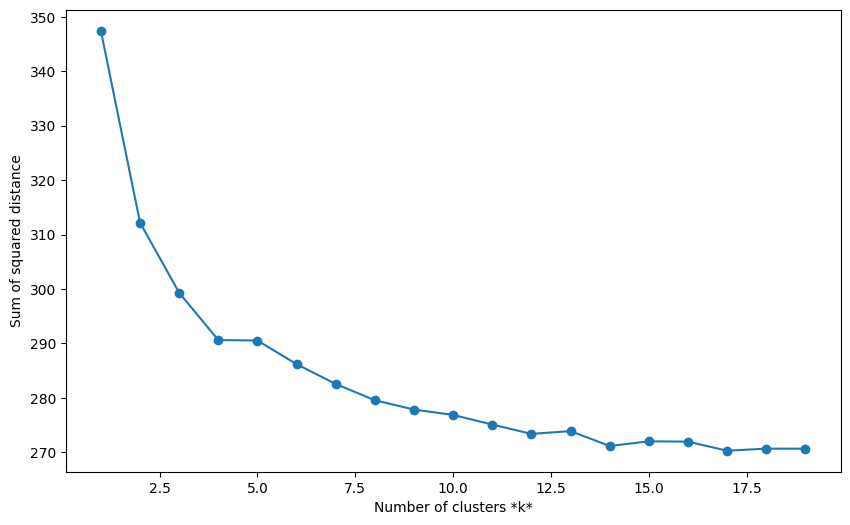

In [90]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(mean_text_embeddings_padding)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(10, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [134]:
kmeans = KMeans(n_clusters=4, verbose=1).fit(mean_text_embeddings_padding)
text_clustering = kmeans.predict(mean_text_embeddings_padding)

Initialization complete
Iteration 0, inertia 495.6134948730469.
Iteration 1, inertia 297.4239501953125.
Iteration 2, inertia 292.71185302734375.
Iteration 3, inertia 291.35870361328125.
Iteration 4, inertia 290.8957824707031.
Iteration 5, inertia 290.6942443847656.
Iteration 6, inertia 290.6419677734375.
Iteration 7, inertia 290.6309509277344.
Iteration 8, inertia 290.63018798828125.
Converged at iteration 8: strict convergence.


In [135]:
embedding_2d = PCA().fit_transform(mean_text_embeddings_padding)[:,:2]
temp = np.append(embedding_2d, text_clustering.reshape((len(text_clustering), 1)), axis=1)
df = pd.DataFrame(temp)

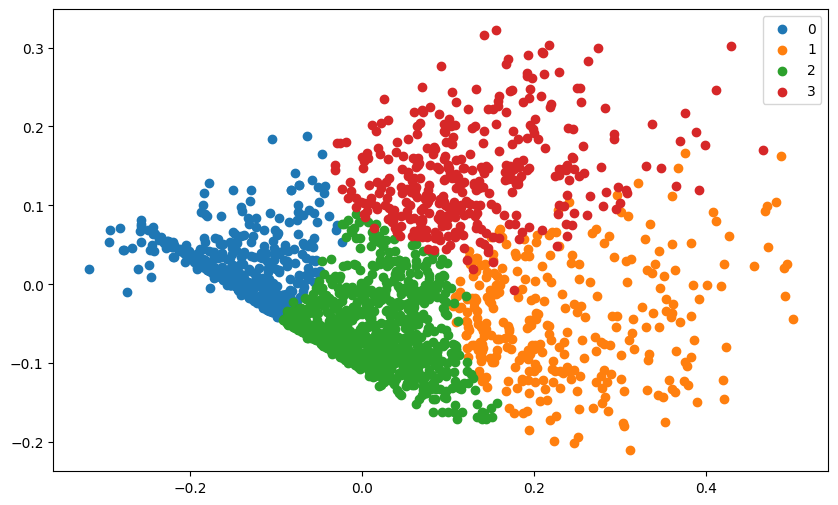

In [136]:
#Getting unique labels
u_labels = np.unique(text_clustering)

#plotting the results
plt.figure(figsize=(10, 6))
for i in u_labels:
    plt.scatter(df[df[2]==i][0] , df[df[2]==i][1], label = i)
plt.legend()
plt.show()

In [137]:
clustered_news = news.copy()
clustered_news.loc[:, len(clustered_news.columns)] = list(text_clustering)

<function matplotlib.pyplot.show(close=None, block=None)>

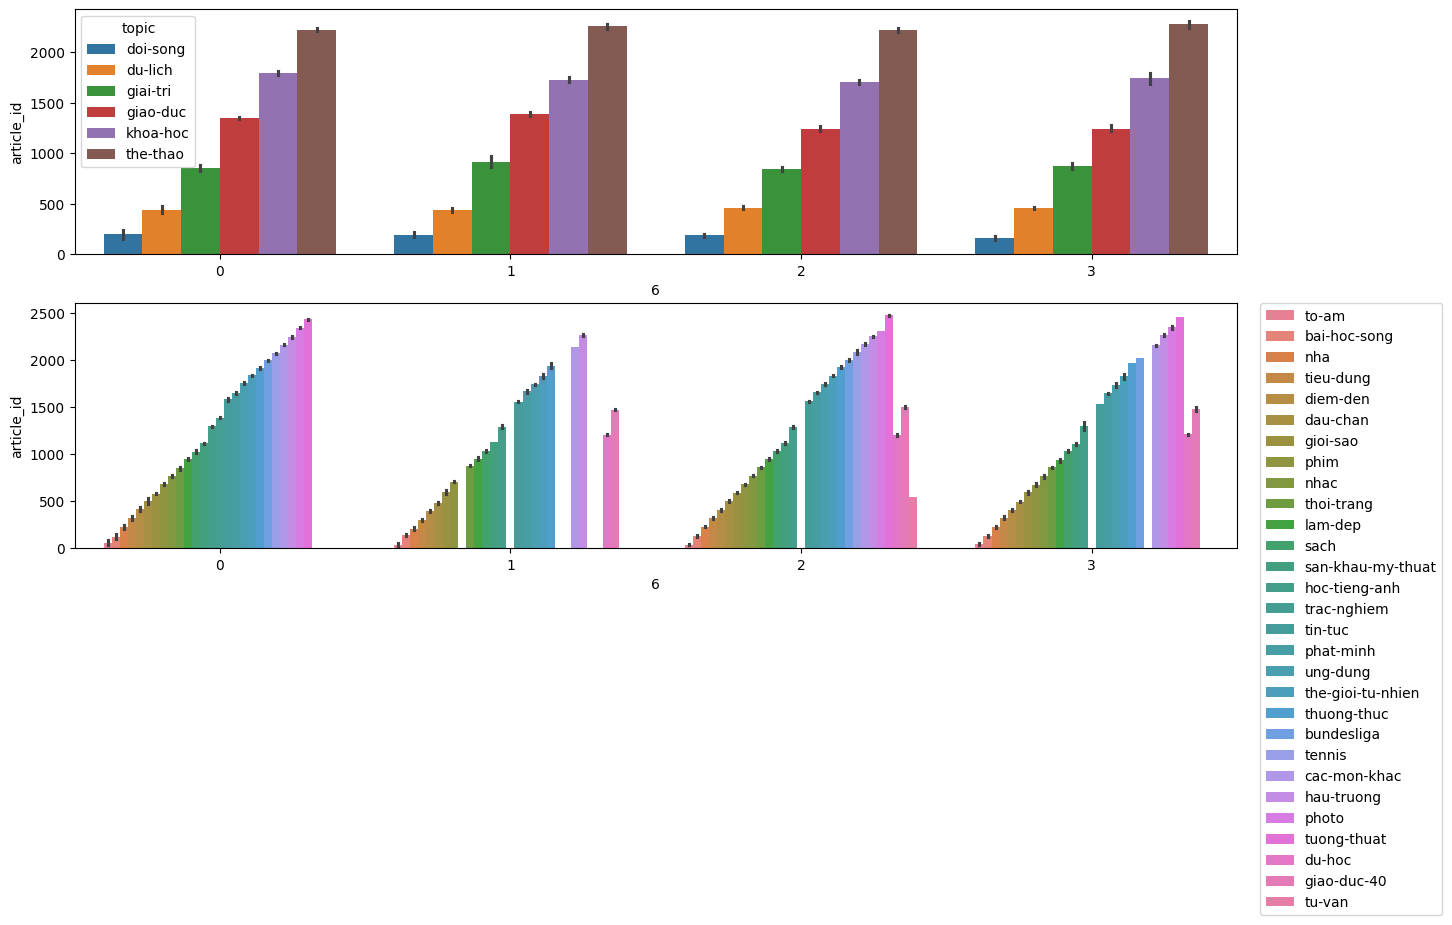

In [139]:
fig, ax = plt.subplots(2, 1, figsize=(15, 7))
sns.barplot(data=clustered_news, y="article_id", x=6, hue="topic", ax=ax[0])
sns.barplot(data=clustered_news, y="article_id", x=6, hue="sub-topic", ax=ax[1])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show